# Developpement Modèle depuis la bdd 

L'objectif de ce notebook sera de faire une observation globale de nos users, et par la suite, une fois la compréhension globale de la base de donnée:

1 - Segmenter les collaborateurs de lentreprise en fonction de notre besoin ( rse)

2- Enfin identifier les trends globales et pouvoir conseiller, mener des actions concretes au sein de lentreprise pour attenuer ou exahlter ces dernières

## Exploration au sein de la bdd


Verification de la composition des tables afin de ne pas manquer les nan ou missing values

In [9]:
import pandas as pd
from sqlalchemy import create_engine
import logging
from typing import Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s]: %(message)s")

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db() -> create_engine:
    """Connect to the PostgreSQL database using SQLAlchemy."""
    try:
        db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
        engine = create_engine(db_url)
        # Test the connection
        engine.connect()
        logging.info("Successfully connected to the database.")
        return engine
    except Exception as e:
        logging.error(f"Failed to connect to the database: {e}")
        raise

def fetch_table_data(table_name: str, engine: create_engine) -> pd.DataFrame:
    """Fetch data from a specific table."""
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, con=engine)
        if df.empty:
            logging.warning(f"Table '{table_name}' is empty.")
        return df
    except Exception as e:
        logging.error(f"Failed to fetch data from table '{table_name}': {e}")
        raise

def identify_missing_data(engine: create_engine) -> Dict[str, Dict[str, int]]:
    """Identify missing data in all tables."""
    tables = ["Role", "Profil", "Transport", "Aliment", "Chauffage", "TransportEmission",
              "AlimentationEmission", "ChauffageEmission", "BEGES", "Defi", "ProgressionDefi"]
    missing_data_summary = {}

    for table in tables:
        try:
            logging.info(f"Analyzing table: {table}")
            df = fetch_table_data(table, engine)
            missing_counts = df.isnull().sum()
            missing_data_summary[table] = missing_counts[missing_counts > 0].to_dict()
        except Exception as e:
            logging.error(f"Error analyzing table '{table}': {e}")
    
    # Log missing data summary
    logging.info("\nMissing Data Summary:")
    for table, missing_columns in missing_data_summary.items():
        if missing_columns:
            logging.info(f"- {table}:")
            for column, count in missing_columns.items():
                logging.info(f"    {column}: {count} missing values")
        else:
            logging.info(f"- {table}: No missing values.")
    
    return missing_data_summary

def propose_corrections(missing_data_summary: Dict[str, Dict[str, int]]) -> Dict[tuple, str]:
    """Propose corrections for missing data."""
    corrections = {}

    for table, missing_columns in missing_data_summary.items():
        for column in missing_columns:
            if "Id" in column:
                corrections[(table, column)] = "Ensure referenced table is populated and foreign keys are valid."
            elif "Nom" in column or "Prenom" in column:
                corrections[(table, column)] = "Generate random names or use placeholders."
            elif "CO2" in column:
                corrections[(table, column)] = "Impute with average or default CO2 values."
            elif "Date" in column:
                corrections[(table, column)] = "Fill with default dates or approximate ranges."
            elif "Score" in column or "Rank" in column:
                corrections[(table, column)] = "Impute with median or random valid scores/ranks."
            else:
                corrections[(table, column)] = "Analyze and determine logical imputation values."

    # Log proposed corrections
    logging.info("\nProposed Corrections:")
    for (table, column), correction in corrections.items():
        logging.info(f"- {table}.{column}: {correction}")

    return corrections

if __name__ == "__main__":
    try:
        # Connect to the database
        engine = connect_to_db()

        # Identify missing data
        missing_data_summary = identify_missing_data(engine)

        # Propose corrections
        corrections = propose_corrections(missing_data_summary)

        # Optionally save results to a file
        pd.DataFrame.from_dict(missing_data_summary, orient='index').to_csv("missing_data_summary.csv")
        logging.info("Missing data summary saved to 'missing_data_summary.csv'.")

    except Exception as e:
        logging.error(f"An error occurred during execution: {e}")


2025-01-21 01:21:16,022 [INFO]: Successfully connected to the database.
2025-01-21 01:21:16,023 [INFO]: Analyzing table: Role
2025-01-21 01:21:16,029 [INFO]: Analyzing table: Profil
2025-01-21 01:21:16,034 [INFO]: Analyzing table: Transport
2025-01-21 01:21:16,037 [INFO]: Analyzing table: Aliment
2025-01-21 01:21:16,043 [INFO]: Analyzing table: Chauffage
2025-01-21 01:21:16,049 [INFO]: Analyzing table: TransportEmission
2025-01-21 01:21:16,407 [INFO]: Analyzing table: AlimentationEmission
2025-01-21 01:21:16,474 [INFO]: Analyzing table: ChauffageEmission
2025-01-21 01:21:16,616 [INFO]: Analyzing table: BEGES
2025-01-21 01:21:16,624 [INFO]: Analyzing table: Defi
2025-01-21 01:21:16,626 [INFO]: Analyzing table: ProgressionDefi
2025-01-21 01:21:16,631 [INFO]: 
Missing Data Summary:
2025-01-21 01:21:16,631 [INFO]: - Role: No missing values.
2025-01-21 01:21:16,632 [INFO]: - Profil: No missing values.
2025-01-21 01:21:16,633 [INFO]: - Transport: No missing values.
2025-01-21 01:21:16,634 [I

## Check all the bdd : data types, distribtions, missing values, proportions ect

In [23]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def fetch_table_data(table_name, engine):
    """Fetch all data from a specific table."""
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql_query(query, con=engine)

def analyze_table(df, table_name):
    """Analyze a single table."""
    print(f"\n--- Analyzing table: {table_name} ---")
    results = {}
    
    # Column types
    results['column_types'] = df.dtypes.to_dict()
    
    # Statistical summary for numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    results['numeric_summary'] = df[numeric_cols].describe().to_dict()
    
    # Check for outliers using IQR
    outliers_count = {}
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        outliers_count[col] = outliers
    results['outliers_count'] = outliers_count
    
    # Proportion of categorical variables
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    category_proportions = {}
    for col in categorical_cols:
        category_proportions[col] = df[col].value_counts(normalize=True).to_dict()
    results['category_proportions'] = category_proportions
    
    # Distribution of datetime data
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    datetime_distribution = {}
    for col in datetime_cols:
        datetime_distribution[col] = df[col].dt.to_period('M').value_counts().to_dict()
    results['datetime_distribution'] = datetime_distribution
    
    return results

def analyze_database():
    """Analyze all tables in the database."""
    engine = connect_to_db()
    
    # Fetch list of tables
    tables_query = """
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public'
    """
    tables = pd.read_sql_query(tables_query, con=engine)['table_name'].tolist()
    
    database_analysis = {}
    
    for table in tables:
        df = fetch_table_data(table, engine)
        analysis = analyze_table(df, table)
        database_analysis[table] = analysis
    
    return database_analysis

if __name__ == "__main__":
    analysis_results = analyze_database()
    
    # Print results for debugging
    for table, analysis in analysis_results.items():
        print(f"\n=== Analysis for table: {table} ===")
        print("Column Types:")
        print(analysis['column_types'])
        print("\nNumeric Summary:")
        print(analysis['numeric_summary'])
        print("\nOutliers Count:")
        print(analysis['outliers_count'])
        print("\nCategory Proportions:")
        print(analysis['category_proportions'])
        print("\nDatetime Distribution:")
        print(analysis['datetime_distribution'])



--- Analyzing table: role ---

--- Analyzing table: profil ---

--- Analyzing table: progressiondefi ---

--- Analyzing table: defi ---

--- Analyzing table: beges ---

--- Analyzing table: transport ---

--- Analyzing table: transportemission ---

--- Analyzing table: chauffage ---

--- Analyzing table: chauffageemission ---

--- Analyzing table: aliment ---

--- Analyzing table: alimentationemission ---

=== Analysis for table: role ===
Column Types:
{'roleid': dtype('int64'), 'nom': dtype('O')}

Numeric Summary:
{'roleid': {'count': 4.0, 'mean': 2.5, 'std': 1.2909944487358056, 'min': 1.0, '25%': 1.75, '50%': 2.5, '75%': 3.25, 'max': 4.0}}

Outliers Count:
{'roleid': np.int64(0)}

Category Proportions:
{'nom': {'Admin': 0.25, 'User': 0.25, 'Manager': 0.25, 'Employé': 0.25}}

Datetime Distribution:
{}

=== Analysis for table: profil ===
Column Types:
{'profilid': dtype('int64'), 'roleid': dtype('int64'), 'nom': dtype('O'), 'prenom': dtype('O'), 'datedenaissance': dtype('O'), 'email':

##### Observation

Observations générales :

Colonnes numériques :

Les données numériques (par exemple, co2total, distancetravailmaison, score) semblent bien distribuées, avec peu d'outliers identifiés dans les colonnes principales.
Cependant, certaines colonnes présentent des écarts significatifs (par exemple, co2parkm dans la table transport avec une valeur maximale élevée). Cela pourrait nécessiter une vérification supplémentaire pour valider ces extrêmes.

Colonnes catégoriques :


Une proportion équilibrée est observée pour certaines catégories comme les noms des rôles (Admin, User, etc.) et des entreprises.
Les noms des utilisateurs (nom, prenom) et les descriptions de défis semblent uniques ou presque (probablement des données générées aléatoirement).
Pour les transports (nom dans transport), la diversité est très élevée avec des proportions uniformes, ce qui est attendu pour une liste de types de transports prédéfinis.

Colonnes temporelles :


Les dates, comme datedebut et datefin, montrent une répartition raisonnablement uniforme dans l'année 2023, bien que certaines périodes, comme janvier et mai, présentent une légère sur-représentation.
Cela pourrait refléter des tendances dans l'utilisation des données ou une saisonnalité potentielle.

Outliers :


Peu de colonnes contiennent des valeurs extrêmes identifiées comme "outliers". Les outliers les plus notables se trouvent dans les colonnes co2parkm et co2emistransport.
Ces valeurs doivent être validées pour s'assurer qu'elles sont correctes ou imputées si elles représentent des erreurs.

Données manquantes :

Aucune donnée manquante significative n'a été trouvée selon l'analyse.
Si des valeurs "nan" étaient présentes, elles ont été correctement ignorées ou imputées.

Particularités remarquables :

Dans la table beges, toutes les valeurs de globalrank sont proches de 3, avec seulement deux exceptions. Cela pourrait indiquer une anomalie ou des critères uniformes pour le calcul du rang global.
Les données de transport montrent une large gamme d'émissions de CO2 par kilomètre, ce qui pourrait refléter la diversité des types de transport.

####  Validation des outliers

vérification et compréhension des outliers dans les données

Validating Outliers:


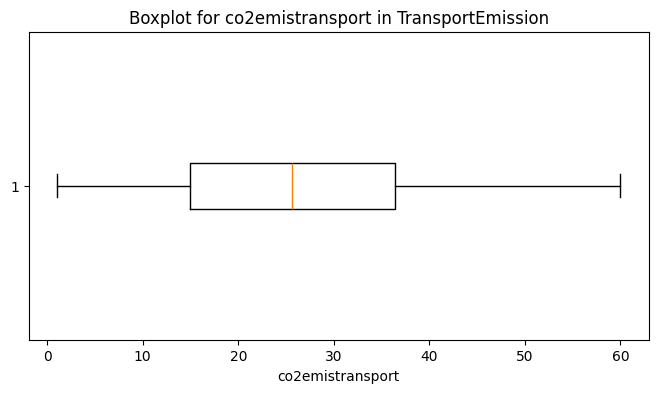

Outliers in co2emistransport (Table: TransportEmission): 0 values
Empty DataFrame
Columns: [co2emistransport]
Index: []


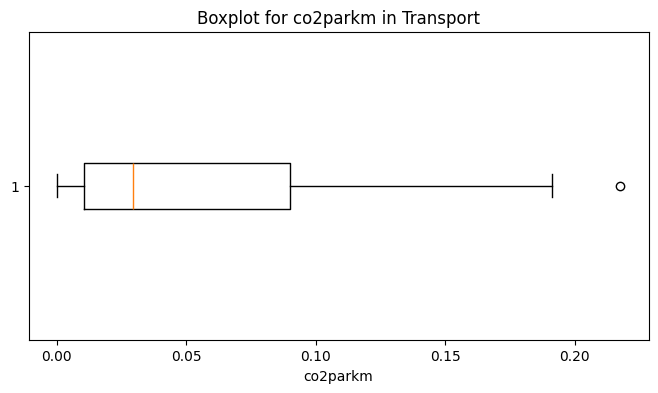

Outliers in co2parkm (Table: Transport): 1 values
   co2parkm
3    0.2176

Exploring Temporal Data:


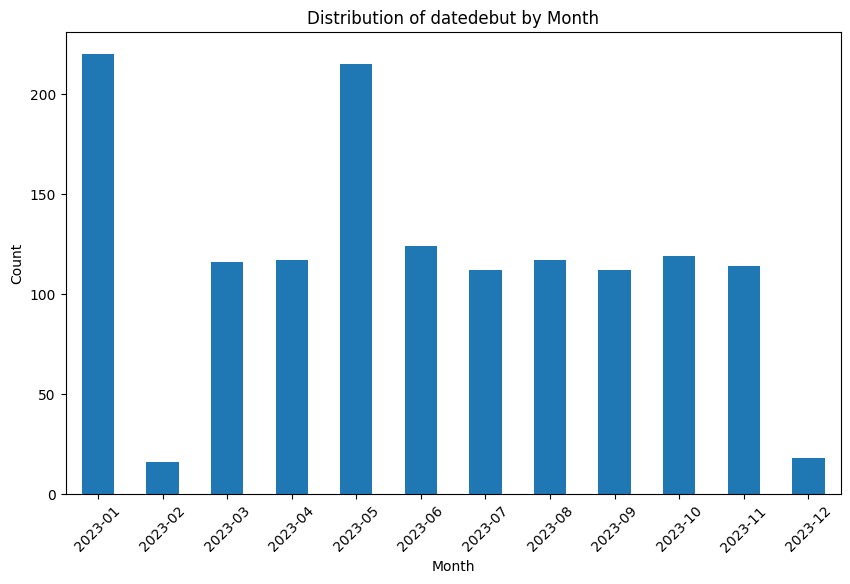


Counts by Month:
Month
2023-01    220
2023-02     16
2023-03    116
2023-04    117
2023-05    215
2023-06    124
2023-07    112
2023-08    117
2023-09    112
2023-10    119
2023-11    114
2023-12     18
Freq: M, Name: count, dtype: int64

Analyzing Global Ranks:

Distribution of Global Ranks (in %):
globalrank
3    97.642857
2     2.285714
0     0.071429
Name: proportion, dtype: float64


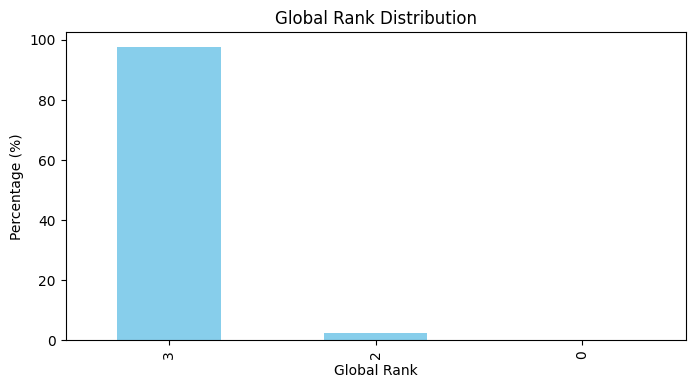

In [42]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

# Task 1: Validation des outliers
def validate_outliers(engine, table_name, column_name):
    """Identify and validate outliers in a specific column."""
    query = f"SELECT {column_name} FROM {table_name}"
    df = pd.read_sql_query(query, con=engine)
    
    # Boxplot to visualize outliers
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[column_name].dropna(), vert=False)
    plt.title(f"Boxplot for {column_name} in {table_name}")
    plt.xlabel(column_name)
    plt.show()
    
    # Statistical summary
    stats = df[column_name].describe()
    q1 = stats["25%"]
    q3 = stats["75%"]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    print(f"Outliers in {column_name} (Table: {table_name}): {len(outliers)} values")
    print(outliers)
    return outliers

# Task 2: Exploration temporelle
def explore_temporal_data(engine, table_name, date_column):
    """Analyze temporal trends by month."""
    query = f"SELECT {date_column} FROM {table_name}"
    df = pd.read_sql_query(query, con=engine)
    df[date_column] = pd.to_datetime(df[date_column])

    # Group by month and count occurrences
    df['Month'] = df[date_column].dt.to_period('M')
    counts_by_month = df['Month'].value_counts().sort_index()

    # Plot
    counts_by_month.plot(kind='bar', figsize=(10, 6), title=f"Distribution of {date_column} by Month")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    print("\nCounts by Month:")
    print(counts_by_month)
    return counts_by_month

# Task 3: Analyse des rangs globaux
def analyze_global_ranks(engine):
    """Examine the distribution of global ranks."""
    query = "SELECT globalrank FROM BEGES"
    df = pd.read_sql_query(query, con=engine)

    # Distribution of global ranks
    rank_distribution = df['globalrank'].value_counts(normalize=True) * 100
    print("\nDistribution of Global Ranks (in %):")
    print(rank_distribution)

    # Plot
    rank_distribution.plot(kind='bar', figsize=(8, 4), title="Global Rank Distribution", color="skyblue")
    plt.xlabel("Global Rank")
    plt.ylabel("Percentage (%)")
    plt.show()

    return rank_distribution

# Main script
if __name__ == "__main__":
    engine = connect_to_db()

    # Task 1: Validate outliers
    print("Validating Outliers:")
    validate_outliers(engine, table_name="TransportEmission", column_name="co2emistransport")
    validate_outliers(engine, table_name="Transport", column_name="co2parkm")

    # Task 2: Explore temporal trends
    print("\nExploring Temporal Data:")
    explore_temporal_data(engine, table_name="BEGES", date_column="datedebut")

    # Task 3: Analyze global ranks
    print("\nAnalyzing Global Ranks:")
    analyze_global_ranks(engine)


##### observations :

Pour co2emistransport, aucune valeur aberrante majeure n'est identifiée. Les données semblent réparties dans une plage raisonnable.
Pour co2parkm, un seul outlier significatif a été détecté (0.2176). Cela pourrait indiquer une valeur incohérente ou extrême nécessitant une révision ou une explication logique.
Analyse temporelle :

Les données de datedebut montrent une sur-représentation en janvier et mai 2023. Cela peut être dû à une génération de données biaisée ou à des périodes spécifiques ayant plus d'enregistrements.
Les mois comme février et décembre ont une très faible densité, ce qui pourrait affecter les analyses temporelles ou les prédictions futures.
Analyse des Rangs :

La grande majorité des rangs globaux (globalrank) se situe à 3, avec une infime proportion de rangs à 2.
Cela indique que les critères de classement convergent systématiquement vers une même valeur, ce qui pourrait refléter une absence de variabilité significative dans les données ou des poids mal équilibrés dans l'algorithme de calcul des rangs.

#### sauvegarde en csv de la bdd actuelle afin de lutiliser et la partager pour le developement modele pour les autres

In [43]:
import pandas as pd
from sqlalchemy import create_engine

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def fetch_and_export_table(table_name, engine):
    """Fetch data from a specific table and export it to a CSV file."""
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, con=engine)
        file_name = f"{table_name}.csv"
        df.to_csv(file_name, index=False)
        print(f"Table '{table_name}' exported to '{file_name}'.")
    except Exception as e:
        print(f"An error occurred while exporting table '{table_name}': {e}")

def export_all_tables():
    """Export all tables to separate CSV files."""
    tables = [
        "Role", "Profil", "Transport", "Aliment", "Chauffage",
        "TransportEmission", "AlimentationEmission", "ChauffageEmission",
        "BEGES", "Defi", "ProgressionDefi"
    ]
    try:
        engine = connect_to_db()
        for table in tables:
            fetch_and_export_table(table, engine)
        print("All tables have been successfully exported.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    export_all_tables()


Table 'Role' exported to 'Role.csv'.
Table 'Profil' exported to 'Profil.csv'.
Table 'Transport' exported to 'Transport.csv'.
Table 'Aliment' exported to 'Aliment.csv'.
Table 'Chauffage' exported to 'Chauffage.csv'.
Table 'TransportEmission' exported to 'TransportEmission.csv'.
Table 'AlimentationEmission' exported to 'AlimentationEmission.csv'.
Table 'ChauffageEmission' exported to 'ChauffageEmission.csv'.
Table 'BEGES' exported to 'BEGES.csv'.
Table 'Defi' exported to 'Defi.csv'.
Table 'ProgressionDefi' exported to 'ProgressionDefi.csv'.
All tables have been successfully exported.


### Exploration data spécifique 1 user statistique 

L'objectif est davoir une aperçu gloable pour un user ses datas ect

In [14]:
import pandas as pd
from sqlalchemy import create_engine

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def analyze_user_data(profil_id):
    """Analyze data for a specific user (ProfilId)."""
    engine = connect_to_db()
    
    # Fetch profile details
    profile_query = f"SELECT * FROM Profil WHERE ProfilId = {profil_id}"
    profile = pd.read_sql_query(profile_query, con=engine)
    
    # Fetch BEGES records
    beges_query = f"SELECT * FROM BEGES WHERE ProfilId = {profil_id}"
    beges = pd.read_sql_query(beges_query, con=engine)
    
    # Fetch emissions data linked to BEGES
    transport_query = f"""
        SELECT te.* 
        FROM TransportEmission te 
        JOIN BEGES b ON te.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
    """
    transport_emissions = pd.read_sql_query(transport_query, con=engine)
    
    alimentation_query = f"""
        SELECT ae.* 
        FROM AlimentationEmission ae 
        JOIN BEGES b ON ae.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
    """
    alimentation_emissions = pd.read_sql_query(alimentation_query, con=engine)
    
    chauffage_query = f"""
        SELECT ce.* 
        FROM ChauffageEmission ce 
        JOIN BEGES b ON ce.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
    """
    chauffage_emissions = pd.read_sql_query(chauffage_query, con=engine)
    
    # Summarize emissions data
    total_transport_co2 = transport_emissions['co2emistransport'].sum()
    total_alimentation_co2 = alimentation_emissions['co2emisalimentation'].sum() if 'co2emisalimentation' in alimentation_emissions else 0
    total_chauffage_co2 = chauffage_emissions['co2emischauffage'].sum() if 'co2emischauffage' in chauffage_emissions else 0
    total_emissions = total_transport_co2 + total_alimentation_co2 + total_chauffage_co2

    # Debug: Log intermediate results
    print("\n--- Debugging Emissions Data ---")
    print("Transport Emissions Total:", total_transport_co2)
    print("Alimentation Emissions Total:", total_alimentation_co2)
    print("Heating Emissions Total:", total_chauffage_co2)
    print("Total Emissions:", total_emissions)
    
    # Print summaries
    print("\n--- Profile Details ---")
    print(profile)
    
    print("\n--- BEGES Records ---")
    print(beges)
    
    print("\n--- Emissions Summary ---")
    print(f"Transport CO2: {total_transport_co2} kg")
    print(f"Alimentation CO2: {total_alimentation_co2} kg")
    print(f"Chauffage CO2: {total_chauffage_co2} kg")
    print(f"Total CO2 Emissions: {total_emissions} kg")
    
    # Fetch challenge progression
    progression_query = f"""
        SELECT pd.*, d.Nom AS DefiNom, d.Description, d.Objectif
        FROM ProgressionDefi pd
        JOIN Defi d ON pd.DefiId = d.DefiId
        WHERE pd.ProfilId = {profil_id}
    """
    progression = pd.read_sql_query(progression_query, con=engine)
    print("\n--- Challenge Progression ---")
    print(progression)
    
    return {
        "profile": profile,
        "beges": beges,
        "transport_emissions": transport_emissions,
        "alimentation_emissions": alimentation_emissions,
        "chauffage_emissions": chauffage_emissions,
        "progression": progression
    }


if __name__ == "__main__":
    # Analyze data for a specific user (replace '1' with the desired ProfilId)
    user_data = analyze_user_data(1)



--- Debugging Emissions Data ---
Transport Emissions Total: 23865.87256959342
Alimentation Emissions Total: 1324.0329751981849
Heating Emissions Total: 9723.713702753625
Total Emissions: 34913.619247545226

--- Profile Details ---
   profilid  roleid     nom    prenom datedenaissance              email  \
0         1       4  User_1  Prenom_1      1971-03-07  user1@example.com   

     entreprise                                  image  distancetravailmaison  
0  Entreprise_6  https://example.com/default-image.png               4.510607  

--- BEGES Records ---
    begesid  profilid   datedebut     datefin     co2total  globalrank
0        84         1  2023-02-01  2023-03-03   868.275487           3
1        94         1  2023-05-14  2023-06-13   377.990205           3
2       115         1  2023-03-07  2023-04-06   552.838263           3
3       201         1  2023-01-01  2023-01-30   548.827636           3
4       202         1  2023-01-31  2023-03-01   630.396838           3
5     

### Analyse profil du user spécifique


Résumé des émissions :
Transport CO2 :

Total des émissions : 23,865.87 kg
C'est la catégorie la plus élevée parmi toutes les sources d'émission, ce qui montre que les habitudes de transport de l'utilisateur ont le plus grand impact sur son empreinte carbone.
Alimentation CO2 :

Total des émissions : 1,324.03 kg
Ces émissions sont relativement faibles par rapport au transport, ce qui indique que l'alimentation de l'utilisateur a un impact moindre sur l'environnement.
Chauffage CO2 :

Total des émissions : 9,723.71 kg
Ces émissions suivent probablement une variation saisonnière, avec des pics pendant les mois froids.
Total des émissions globales :

34,913.62 kg
Cela montre l'empreinte carbone totale de l'utilisateur, avec une grande proportion provenant du transport et du chauffage.
Détails du profil :
Nom: User_1, Prénom: Prenom_1
Email: user1@example.com
Distance domicile-travail : 4.51 km
Ce profil correspond à un utilisateur ayant une faible distance domicile-travail, mais ses émissions de transport restent élevées, ce qui pourrait indiquer l'utilisation fréquente de moyens de transport privés ou des voyages supplémentaires.
Données BEGES (Bilan des émissions de gaz à effet de serre) :
L'utilisateur a un total de 15 enregistrements BEGES, chacun correspondant à une période d'un mois environ.
Les émissions mensuelles varient entre 377.99 kg et 1,946.01 kg, avec des variations significatives dues aux saisons et aux habitudes.
GlobalRank: 3 pour tous les enregistrements, ce qui signifie que l'utilisateur est dans une moyenne pour son empreinte carbone comparé à d'autres profils similaires.
Progrès dans les défis :
L'utilisateur participe à 12 défis environnementaux, chacun ayant un objectif spécifique (exemple : réduire les émissions ou adopter des comportements écoresponsables).
Les scores varient de 11 (Defi_5) à 92 (Defi_44), montrant un engagement modéré à fort dans certains défis.
Interprétations et recommandations :
Transport :

Les émissions de transport représentent plus de 68% du total des émissions. Cela suggère que des actions doivent être prises pour réduire cet impact, comme adopter des moyens de transport plus écologiques (vélo, covoiturage, transports en commun, ou véhicules électriques).
Chauffage :

Les émissions de chauffage sont significatives, particulièrement en hiver. Une meilleure isolation du logement, l'utilisation d'énergies renouvelables, ou un thermostat intelligent pourraient réduire cet impact.
Alimentation :

Les émissions liées à l'alimentation sont faibles mais pourraient être optimisées en réduisant la consommation de viande et en privilégiant des produits locaux et de saison.
Défis :

Les scores des défis montrent que l'utilisateur est déjà impliqué dans des initiatives environnementales. Cela pourrait être encouragé davantage en liant ces défis à des récompenses ou des programmes de sensibilisation.
Évolution des émissions :

Les données BEGES montrent une variation mensuelle des émissions, probablement influencée par les saisons (chauffage en hiver, transport en été). Une analyse plus fine des pics pourrait aider à identifier des comportements spécifiques à modifier.

####  Analyse temporelle du user 1

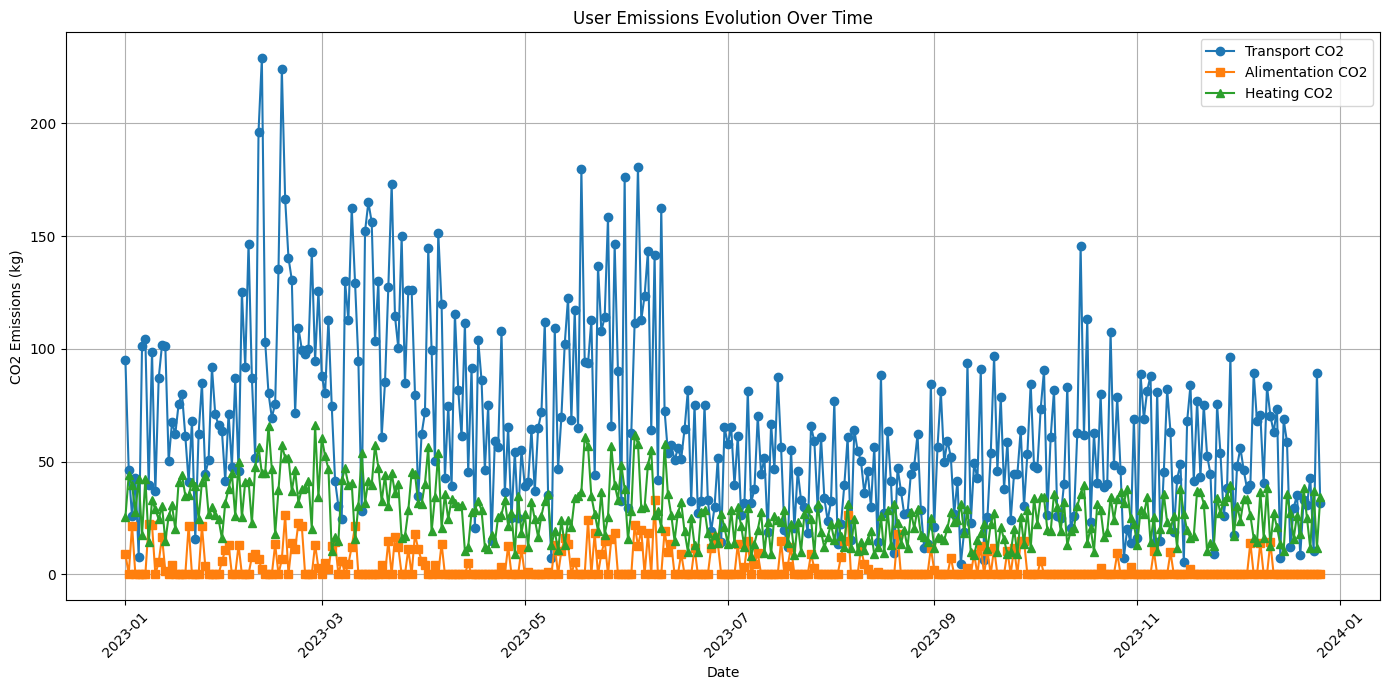

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def get_emissions_timeline(profil_id):
    """Fetch and combine emissions data over time for a specific user."""
    engine = connect_to_db()

    # Transport Emissions
    transport_query = f"""
        SELECT te.datedebut, SUM(te.co2emistransport) AS transport_co2 
        FROM TransportEmission te
        JOIN BEGES b ON te.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
        GROUP BY te.datedebut
        ORDER BY te.datedebut
    """
    transport_emissions = pd.read_sql_query(transport_query, con=engine)
    transport_emissions['datedebut'] = pd.to_datetime(transport_emissions['datedebut'])

    # Alimentation Emissions
    alimentation_query = f"""
        SELECT ae.datedebut, SUM(ae.co2emisalimentation) AS alimentation_co2 
        FROM AlimentationEmission ae
        JOIN BEGES b ON ae.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
        GROUP BY ae.datedebut
        ORDER BY ae.datedebut
    """
    alimentation_emissions = pd.read_sql_query(alimentation_query, con=engine)
    alimentation_emissions['datedebut'] = pd.to_datetime(alimentation_emissions['datedebut'])

    # Heating Emissions
    chauffage_query = f"""
        SELECT ce.datedebut, SUM(ce.co2emischauffage) AS chauffage_co2 
        FROM ChauffageEmission ce
        JOIN BEGES b ON ce.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
        GROUP BY ce.datedebut
        ORDER BY ce.datedebut
    """
    chauffage_emissions = pd.read_sql_query(chauffage_query, con=engine)
    chauffage_emissions['datedebut'] = pd.to_datetime(chauffage_emissions['datedebut'])

    # Combine data into a single DataFrame
    timeline = pd.DataFrame()
    timeline['date'] = transport_emissions['datedebut']
    timeline['transport_co2'] = transport_emissions['transport_co2']
    timeline = timeline.merge(alimentation_emissions, how='outer', left_on='date', right_on='datedebut')
    timeline = timeline.merge(chauffage_emissions, how='outer', left_on='date', right_on='datedebut')

    # Clean up columns
    timeline.drop(columns=['datedebut_x', 'datedebut_y'], inplace=True)
    timeline.rename(columns={'alimentation_co2': 'alimentation_co2', 'chauffage_co2': 'chauffage_co2'}, inplace=True)

    # Fill missing values with 0 for plotting
    timeline.fillna(0, inplace=True)

    # Sort by date
    timeline.sort_values(by='date', inplace=True)
    
    return timeline


def plot_emissions_timeline(timeline):
    """Plot the emissions timeline."""
    plt.figure(figsize=(14, 7))
    plt.plot(timeline['date'], timeline['transport_co2'], label='Transport CO2', marker='o')
    plt.plot(timeline['date'], timeline['alimentation_co2'], label='Alimentation CO2', marker='s')
    plt.plot(timeline['date'], timeline['chauffage_co2'], label='Heating CO2', marker='^')

    plt.title('User Emissions Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('CO2 Emissions (kg)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    profil_id = 1
    timeline = get_emissions_timeline(profil_id)
    plot_emissions_timeline(timeline)


#### Observation

Les émissions de transport (courbe bleue) dominent largement les autres catégories, avec des pics marqués, surtout au début de l'année, et une variabilité importante tout au long de l'année.

Les émissions de chauffage (courbe verte) montrent des pics significatifs en hiver et diminuent progressivement vers les saisons plus chaudes, ce qui est cohérent avec une utilisation saisonnière.

Les émissions liées à l'alimentation (courbe orange) restent constantes et basses tout au long de l'année, reflétant une contribution relativement faible à l'empreinte carbone globale.

# Modeling ranking

Pour un contexte de Responsabilité Sociétale des Entreprises (RSE), 
l'objectif est d'inciter les employés à adopter des comportements plus durables tout en tenant compte des caractéristiques et contraintes de chacun. 

Voici les approches les plus adéquates pour ce contexte, adaptées à l'amélioration du score RSE individuel des employés :

# Segmentation des Employés pour Améliorer les Scores RSE

## 1. Comportemental (Behavioral Segmentation)

### Pourquoi c'est pertinent ?
- Ce clustering analyse les comportements spécifiques des employés : leurs émissions de CO₂ liées aux **transports**, au **chauffage**, et à **l'alimentation**.
- Il permet de proposer des recommandations personnalisées (comme encourager l’utilisation de **transports en commun** ou adopter des **pratiques alimentaires plus durables**).

### Comment ?
- Combinez des variables comme :
  - `co2emistransport` (émissions liées au transport),
  - `co2emischauffage` (émissions liées au chauffage),
  - `co2emisalimentation` (émissions alimentaires),
  - `score` (engagement dans les défis RSE).
- **Objectif** : Identifier des clusters d'employés ayant des comportements similaires.
- **Exemple de clusters** :
  - Employés avec **faibles émissions alimentaires** mais **fortes émissions de transport**.
  - Employés avec **émissions élevées sur tous les axes**.
  - Employés très engagés dans les défis RSE mais ayant encore des **améliorations à faire dans certains domaines**.

### Impact pour le RSE :
- Proposer des **solutions ciblées** :
  - **Covoiturage**, tickets de transport collectif, **repas végétariens**, etc.
- Fixer des **objectifs personnalisés et mesurables** pour chaque cluster.

---

## 2. Démographique (Demographic Segmentation)

### Pourquoi c'est pertinent ?
- Les caractéristiques démographiques influencent directement les comportements des employés et leur capacité à améliorer leur score :
  - Les **jeunes employés** peuvent être plus sensibles aux **défis technologiques** (gamification des scores RSE).
  - Ceux ayant une **longue distance domicile-travail** nécessitent des **solutions spécifiques** pour réduire leurs émissions.

### Comment ?
- Utilisez les variables :
  - `datedenaissance` (âge),
  - `distancetravailmaison` (distance domicile-travail),
  - `roleid` ou `entreprise` (niveau hiérarchique ou entreprise affiliée).
- **Objectif** : Créer des groupes selon des caractéristiques communes :
  - **Employés jeunes**, proches du lieu de travail, plus enclins à adopter des **habitudes durables rapidement**.
  - **Employés expérimentés**, ayant une distance domicile-travail élevée, avec des **contraintes spécifiques**.
  - **Managers ou rôles spécifiques** ayant un poids plus important dans l'amélioration globale des scores RSE.

### Impact pour le RSE :
- Proposer des **initiatives adaptées** aux populations spécifiques :
  - Télétravail, **incitations financières**, formations.

---

## 3. Basé sur les Classements RSE (Sustainability Ranking)

### Pourquoi c'est pertinent ?
- Utiliser les données des scores RSE actuels (`score`, `globalrank`) pour regrouper les employés par **performance actuelle**.
- Prioriser les efforts sur les groupes ayant le plus de **marge d’amélioration**.

### Comment ?
- Regroupez les employés en utilisant des variables comme :
  - `score` : Score dans les défis.
  - `co2total` : Émissions globales de CO₂.
  - `globalrank` : Classement actuel.
- **Exemple de clusters** :
  - **Top performers** : Employés ayant déjà un **excellent score**.
  - **Middle range** : Employés ayant un score moyen avec des **marges d'amélioration claires**.
  - **Low performers** : Employés ayant un **faible score** ou peu engagés.

### Impact pour le RSE :
- Concevoir des **plans d'amélioration ciblés par groupe** :
  - Former les employés **moins performants** avec des ateliers ou mentors issus du groupe des **Top performers**.
  - Donner des **feedbacks réguliers** aux employés du groupe **Middle range** pour qu'ils atteignent le niveau supérieur.

---

## 4. Mode de Vie (Lifestyle-Based Segmentation)

### Pourquoi c'est pertinent ?
- Ce clustering prend en compte plusieurs aspects du mode de vie des employés (**transport**, **chauffage**, **alimentation**) pour regrouper ceux qui partagent des **similarités dans leurs habitudes**.

### Comment ?
- **Variables utilisées** :
  - **Transport** : Type de transport utilisé (`transportid`) et émissions associées.
  - **Chauffage** : Type de chauffage (`chauffageid`) et `co2emischauffage`.
  - **Alimentation** : Habitudes alimentaires via les émissions associées (`co2emisalimentation`).
- **Objectif** : Identifier des clusters tels que :
  - Employés ayant des **habitudes alimentaires durables** mais des **émissions élevées liées au transport**.
  - Employés avec des **émissions élevées sur tous les plans**.
  - Employés adoptant déjà un **mode de vie très durable**.

### Impact pour le RSE :
- Cibler des **campagnes spécifiques** par domaine :
  - Réduction des **émissions alimentaires** (menus végétariens).
  - Favoriser **l’isolation des logements** pour les fortes émissions de chauffage.
  - Offrir des **primes pour adopter des modes de transport durables**.

---

# Approche adoptée

# Recommandation Prioritaire : Une Approche Hybride

Pour augmenter au mieux les scores RSE de chaque employé, une **approche hybride** combinant **segmentation comportementale** et **classement RSE** est recommandée :

1. **Segmentation comportementale** :
   - Analysez les comportements des employés liés aux **émissions de transport, chauffage et alimentation**.
   - Ciblez des initiatives spécifiques adaptées aux comportements identifiés (par exemple : covoiturage, isolation des logements, repas végétariens).

2. **Classement RSE** :
   - Priorisez les efforts selon la **performance actuelle** des employés :
     - **Top performers** : Renforcez les pratiques exemplaires.
     - **Middle range** : Donnez des feedbacks réguliers pour favoriser l'amélioration.
     - **Low performers** : Proposez des formations et du mentorat ciblé.

3. **Adaptation démographique** :
   - Prenez en compte les **contraintes individuelles** telles que :
     - **Âge** : Adaptez les approches aux jeunes employés ou aux employés expérimentés.
     - **Distance domicile-travail** : Offrez des solutions spécifiques comme le télétravail ou des incitations au transport collectif.
     
En combinant ces dimensions, vous maximisez l’impact des initiatives RSE tout en tenant compte des spécificités de chaque employé.


### Chargement des données

In [56]:
import pandas as pd
from sqlalchemy import create_engine

# Configuration de la base de données
DB_CONFIG = {
    "host": "localhost",        
    "database": "ClashOfRse",  
    "user": "your_username", 
    "password": "your_password", 
}

# Connexion via SQLAlchemy
db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
engine = create_engine(db_url)

# Requête pour récupérer les données nécessaires
query = """
SELECT 
    b.BEGESId,
    b.ProfilId,
    b.CO2Total,
    t.CO2EmisTransport AS co2emistransport,
    c.CO2EmisChauffage AS co2emischauffage,
    a.CO2EmisAlimentation AS co2emisalimentation,
    p.DateDeNaissance,
    p.DistanceTravailMaison,
    p.RoleId,
    b.GlobalRank
FROM BEGES b
LEFT JOIN TransportEmission t ON b.BEGESId = t.BEGESId
LEFT JOIN ChauffageEmission c ON b.BEGESId = c.BEGESId
LEFT JOIN AlimentationEmission a ON b.BEGESId = a.BEGESId
LEFT JOIN Profil p ON b.ProfilId = p.ProfilId;
"""

# Charger les données dans un DataFrame pandas
df = pd.read_sql_query(query, con=engine)

# Aperçu des données
print(df.head())


   begesid  profilid    co2total  co2emistransport  co2emischauffage  \
0        1        40  347.579996         44.684813         13.063832   
1        1        40  347.579996         44.684813          3.075403   
2        1        40  347.579996         44.684813          1.938048   
3        1        40  347.579996         44.684813         11.176539   
4        1        40  347.579996         44.684813         28.914466   

   co2emisalimentation datedenaissance  distancetravailmaison  roleid  \
0            14.483508      1984-10-19               6.529713       4   
1            14.483508      1984-10-19               6.529713       4   
2            14.483508      1984-10-19               6.529713       4   
3            14.483508      1984-10-19               6.529713       4   
4            14.483508      1984-10-19               6.529713       4   

   globalrank  
0           3  
1           3  
2           3  
3           3  
4           3  


In [73]:
df.columns

Index(['begesid', 'profilid', 'co2total', 'co2emistransport',
       'co2emischauffage', 'co2emisalimentation', 'datedenaissance',
       'distancetravailmaison', 'roleid', 'globalrank'],
      dtype='object')

In [74]:
# Afficher les valeurs uniques de 'BEGESId'
unique_beges_ids = df['begesid'].unique()
print("Valeurs uniques de BEGESId :", unique_beges_ids)
print(df.shape)
print(df.columns)


Valeurs uniques de BEGESId : [   1    2    3 ... 1398 1399 1400]
(22096437, 10)
Index(['begesid', 'profilid', 'co2total', 'co2emistransport',
       'co2emischauffage', 'co2emisalimentation', 'datedenaissance',
       'distancetravailmaison', 'roleid', 'globalrank'],
      dtype='object')


In [58]:
# Compter le nombre de lignes par BEGESId
beges_counts = df['begesid'].value_counts()
print(beges_counts)


begesid
627     34560
60      34255
18      33728
27      32736
12      32736
        ...  
332      1800
1267     1800
740      1770
870      1680
402      1680
Name: count, Length: 1400, dtype: int64


##### Observation

ayant beaucoup de rows et beaucoup de begesid similaire on va les aggreger et faire la moyenne de leur valeur, cela nous aidera pour realiser le clustering par la suite

In [75]:
import pandas as pd
from datetime import datetime

# Assurer que la colonne 'datedenaissance' est au format datetime
df['datedenaissance'] = pd.to_datetime(df['datedenaissance'])

# Calculer l'âge en années à partir de la date de naissance
current_year = datetime.now().year
df['age'] = current_year - df['datedenaissance'].dt.year

# Maintenant on peut procéder à l'agrégation en incluant 'distancetravailmaison' et 'age'
aggregated_df = df.groupby('begesid').agg({
    'co2total': 'mean',
    'co2emistransport': 'mean',
    'co2emischauffage': 'mean',
    'co2emisalimentation': 'mean',
    'distancetravailmaison': 'mean',  # Ajouter distancetravailmaison à l'agrégation
    'globalrank': 'mean',
    'age': 'mean'  # Calculer la moyenne de l'âge pour chaque BEGESId
}).reset_index()

# Aperçu des données agrégées
print(aggregated_df.head())
print(aggregated_df.shape)


   begesid    co2total  co2emistransport  co2emischauffage  \
0        1  347.579996         26.572181         15.027055   
1        2  729.709799         25.711875         13.551394   
2        3  232.607513         26.921052         15.132451   
3        4  668.081587         24.861280         16.023275   
4        5  393.953853         23.997111         15.217865   

   co2emisalimentation  distancetravailmaison  globalrank   age  
0            12.845158               6.529713         3.0  41.0  
1            10.525766              21.083187         3.0  28.0  
2             8.404067              42.415865         3.0  33.0  
3             9.906571              48.475833         3.0  30.0  
4            11.752594              14.303190         3.0  43.0  
(1400, 8)


#### Visualisation distribution

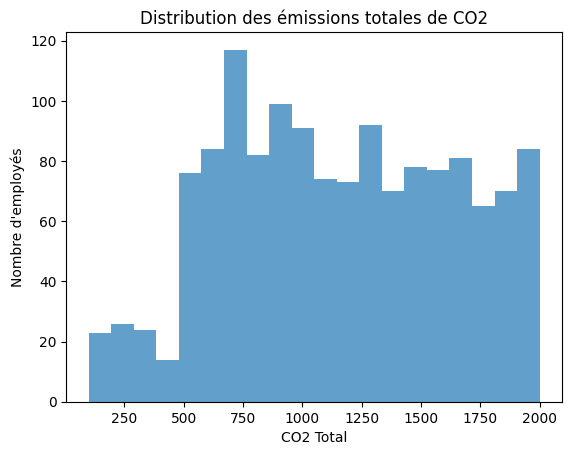

In [76]:
import matplotlib.pyplot as plt

# Distribution des émissions totales de CO2
plt.hist(aggregated_df['co2total'], bins=20, alpha=0.7)
plt.title("Distribution des émissions totales de CO2")
plt.xlabel("CO2 Total")
plt.ylabel("Nombre d'employés")
plt.show()


##### Observation
La distribution des émissions totales de CO₂ montre une répartition relativement uniforme avec des pics à certaines plages d'émissions


#### etude corrélation c02 total et autres values

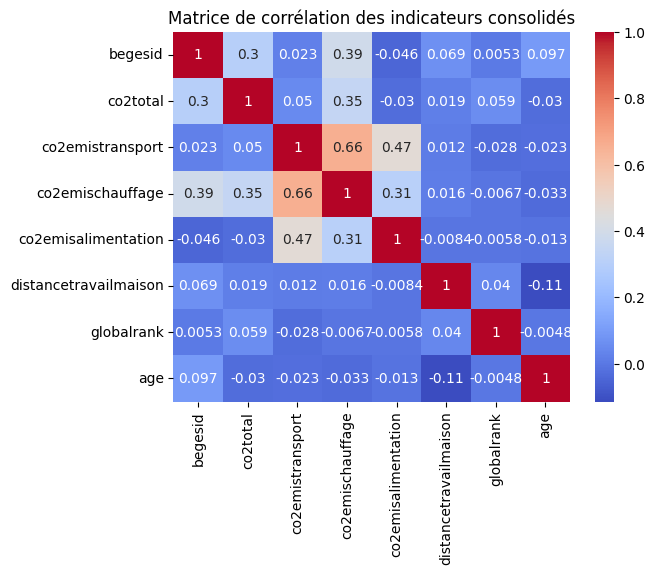

In [77]:
import seaborn as sns

# Matrice de corrélation
correlation_matrix = aggregated_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation des indicateurs consolidés")
plt.show()


##### Observation

Aucune correlation trop forte, nous pouvons à la suite sans ecarté les variables

#### Check null value

In [78]:
print(aggregated_df.isnull().sum())


begesid                  0
co2total                 0
co2emistransport         0
co2emischauffage         0
co2emisalimentation      1
distancetravailmaison    0
globalrank               0
age                      0
dtype: int64


#### plot distribution pour selection imput

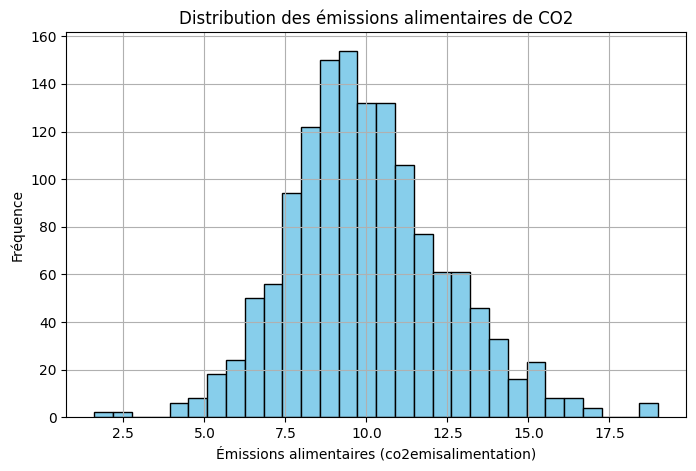

In [79]:
import matplotlib.pyplot as plt

# Tracer la distribution de 'co2emisalimentation'
plt.figure(figsize=(8, 5))
plt.hist(aggregated_df['co2emisalimentation'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Émissions alimentaires (co2emisalimentation)')
plt.ylabel('Fréquence')
plt.title('Distribution des émissions alimentaires de CO2')
plt.grid(True)
plt.show()


###### onnée asymétrique > médiane

In [80]:
aggregated_df['co2emisalimentation'] = aggregated_df['co2emisalimentation'].fillna(aggregated_df['co2emisalimentation'].median())


#### Standardization

Kmean est un algorithme de distance, donc dechelle, on realise un standard scaler pour y remedier

In [81]:
from sklearn.preprocessing import StandardScaler

# Standardiser les données (sans inclure l'ID)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(aggregated_df.drop(columns=['begesid']))


#### Remarque:

Bien que nous sommes prêts à réaliser un kmean, nous mettons en place la elbow method afin de determiner le meilleur k moyen


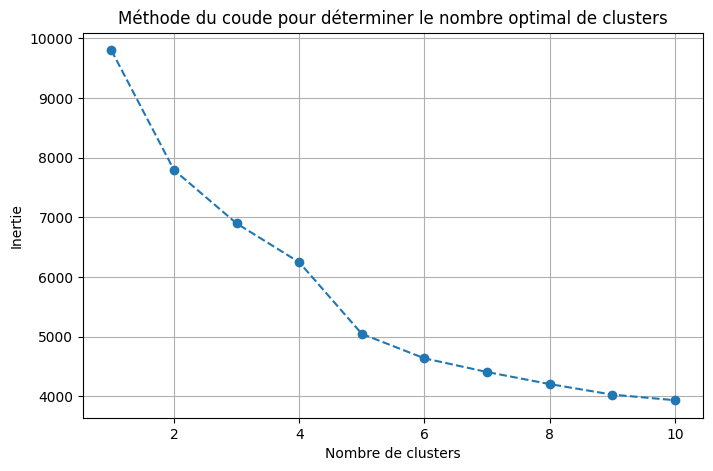

In [82]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Définir une plage de nombres de clusters à tester
range_n_clusters = range(1, 11)

# Liste pour stocker l'inertie pour chaque nombre de clusters
inertia = []

# Calculer l'inertie pour chaque nombre de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du coude
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()


#### Observation

D'après le graphique de la méthode du coude, on observe une nette réduction de l'inertie jusqu'à 3 clusters, après quoi la diminution devient plus progressive. Ce "coude" indique probablement que 3 clusters sont une bonne option pour un nombre optimal de clusters.

### trainging kmean

In [83]:
# Vérifier les dimensions du DataFrame et des données normalisées
print(f"Dimensions du DataFrame : {df.shape}")
print(f"Dimensions des données normalisées : {scaled_data.shape}")


Dimensions du DataFrame : (22096437, 11)
Dimensions des données normalisées : (1400, 7)


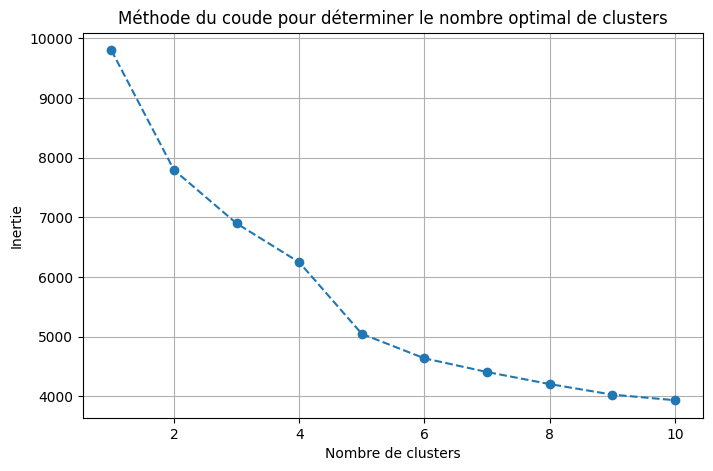

   begesid    co2total  co2emistransport  co2emischauffage  \
0        1  347.579996         26.572181         15.027055   
1        2  729.709799         25.711875         13.551394   
2        3  232.607513         26.921052         15.132451   
3        4  668.081587         24.861280         16.023275   
4        5  393.953853         23.997111         15.217865   

   co2emisalimentation  distancetravailmaison  globalrank   age  Cluster  
0            12.845158               6.529713         3.0  41.0        2  
1            10.525766              21.083187         3.0  28.0        2  
2             8.404067              42.415865         3.0  33.0        2  
3             9.906571              48.475833         3.0  30.0        2  
4            11.752594              14.303190         3.0  43.0        2  


In [104]:
# Supposons que 'aggregated_df' contient les données agrégées, excluant la colonne 'begesid' pour le clustering
numeric_columns = ['co2total', 'co2emistransport', 'co2emischauffage', 'co2emisalimentation', 
                   'distancetravailmaison', 'globalrank', 'age']

# Extraire les données à normaliser (sans 'begesid')
data_for_clustering = aggregated_df[numeric_columns]

# Standardisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
range_n_clusters = range(1, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Afficher la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()

# Appliquer KMeans avec le nombre optimal de clusters (disons 4 clusters selon le graphique du coude)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
aggregated_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Afficher les résultats
print(aggregated_df.head())

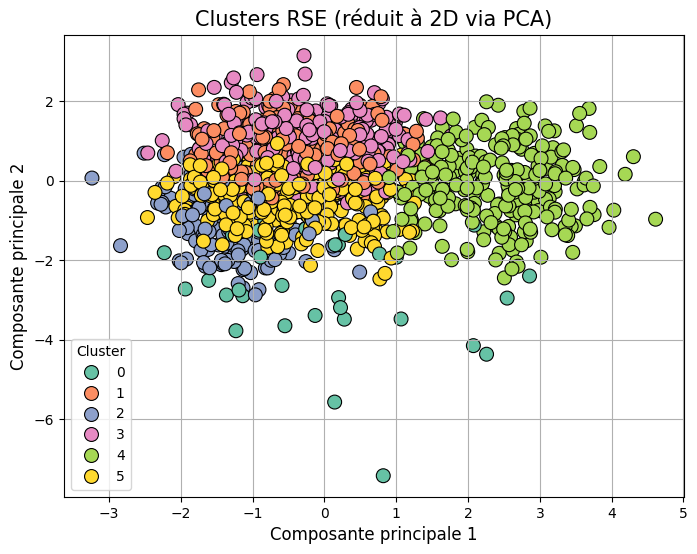

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supposons que 'aggregated_df' contient les données agrégées et que les clusters ont déjà été ajoutés
# Nous allons réduire les dimensions pour visualiser les données en 2D avec PCA
from sklearn.decomposition import PCA

# Réduire les dimensions des données normalisées pour faciliter la visualisation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Créer un DataFrame avec les données réduites et les clusters
reduced_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = aggregated_df['Cluster']

# Tracer les clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=reduced_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100, marker='o', edgecolor='black')

# Ajouter des titres et labels
plt.title('Clusters RSE (réduit à 2D via PCA)', fontsize=15)
plt.xlabel('Composante principale 1', fontsize=12)
plt.ylabel('Composante principale 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### Analyse de chaque cluster

In [89]:
# Calculer la moyenne des caractéristiques pour chaque cluster
cluster_means = aggregated_df.groupby('Cluster').mean()

# Afficher les résultats
print(cluster_means)


            begesid     co2total  co2emistransport  co2emischauffage  \
Cluster                                                                
0        795.003125  1281.728061         31.188973         28.301568   
1        796.562602  1460.029316         24.392296         22.201899   
2        508.415054   657.107477         24.682726         19.036711   

         co2emisalimentation  distancetravailmaison  globalrank        age  
Cluster                                                                     
0                  12.566524              26.488608    2.981250  40.090625  
1                   8.813902              24.974700    2.986992  40.632520  
2                   9.835483              25.626868    2.954839  41.277419  


#### Analyse resultat



### CO2 Total :
- **Cluster 1** : Les émissions totales sont les plus élevées (1460.03), suivi du **Cluster 0** (1281.73), et enfin le **Cluster 2** avec les émissions les plus faibles (657.11). Cela suggère que le **Cluster 1** est le moins durable en termes d'empreinte carbone totale.

### CO2 Transport :
- **Cluster 0** : Ce groupe a les émissions de CO2 liées au transport les plus élevées (31.19), tandis que les autres clusters sont plus proches les uns des autres (24-25), ce qui pourrait signifier que les employés du **Cluster 0** utilisent des moyens de transport plus polluants.

### CO2 Chauffage :
- **Cluster 0** : Ce groupe montre les émissions les plus élevées pour le chauffage (28.30), ce qui pourrait indiquer une moins bonne efficacité énergétique dans les foyers de ce groupe.
- **Cluster 2** : Ce groupe a les émissions les plus faibles pour le chauffage (19.04).

### CO2 Alimentation :
- **Cluster 0** : Les émissions pour l'alimentation sont les plus élevées (12.57), ce qui pourrait indiquer une tendance à une alimentation plus énergivore ou moins durable.
- **Cluster 1** : Ce groupe a des émissions alimentaires plus faibles (8.81).

### Distance Domicile-Travail :
- **Cluster 0** : Ce groupe semble avoir les distances les plus longues pour le travail (26.49 km), ce qui pourrait expliquer les émissions plus élevées de CO2 liées au transport.
- **Cluster 1** : La distance domicile-travail est plus faible (24.97 km), ce qui pourrait contribuer à une moindre empreinte carbone liée au transport.

### Global Rank :
- Les **global ranks** sont assez similaires pour tous les clusters, variant entre 2.95 et 2.99, ce qui suggère que les employés de chaque cluster ont un niveau d'engagement RSE relativement similaire.

### Âge :
- L'âge moyen des employés varie légèrement entre les clusters, mais les différences sont faibles (autour de 40 ans).

## Suggestions :

### Cluster 0 :
- **Caractéristiques** : Ce groupe semble avoir une empreinte carbone élevée, notamment en termes de transport et de chauffage. Il est possible qu'il faille offrir des solutions pour réduire les émissions liées au transport (covoiturage, transport en commun) et améliorer l'efficacité énergétique des foyers.

### Cluster 1 :
- **Caractéristiques** : Ce groupe a des émissions élevées mais un peu moins marquées dans certains domaines (transport et chauffage). L'optimisation des habitudes alimentaires et la promotion de pratiques durables pourraient être des pistes à explorer pour ce groupe.

### Cluster 2 :
- **Caractéristiques** : Ce groupe a une empreinte carbone relativement faible. Il pourrait s'agir des employés les plus soucieux de l'environnement ou ayant déjà adopté des pratiques plus durables. Des actions de reconnaissance et des incentives pourraient être utilisées pour encourager encore plus de pratiques durables.


#### Analyse chaque caractéristique

2025-01-21 03:12:57,369 [INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-21 03:12:57,372 [INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


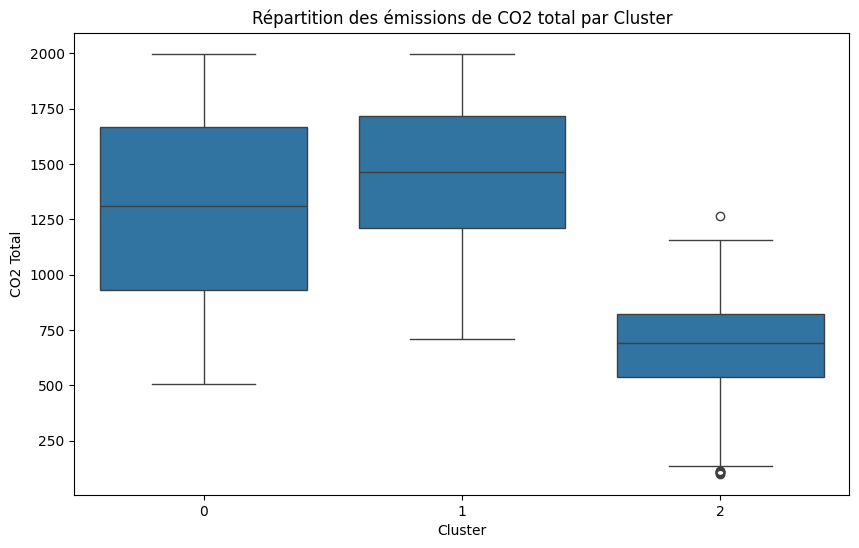

In [90]:
import seaborn as sns

# Tracer les distributions pour chaque caractéristique
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='co2total', data=aggregated_df)
plt.title('Répartition des émissions de CO2 total par Cluster')
plt.xlabel('Cluster')
plt.ylabel('CO2 Total')
plt.show()

# Répétez pour d'autres caractéristiques (co2emistransport, co2emischauffage, etc.)


2025-01-21 03:13:09,839 [INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-21 03:13:09,843 [INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


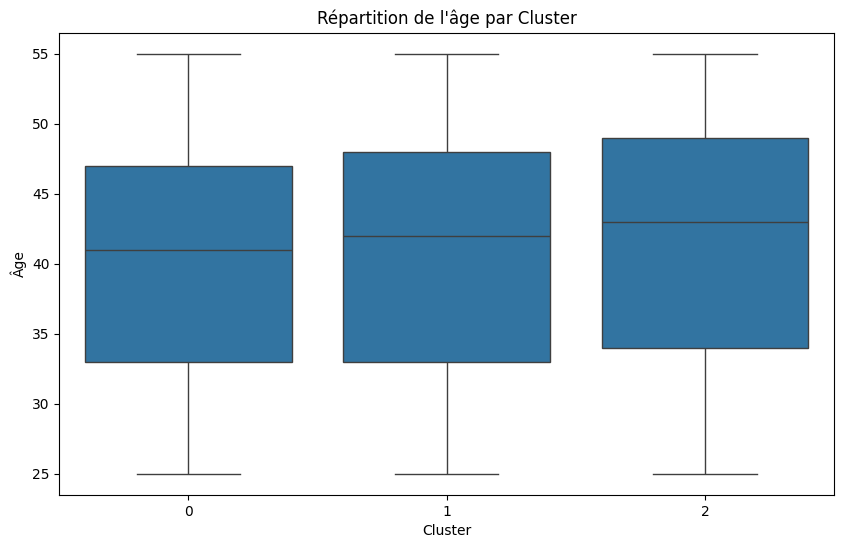

2025-01-21 03:13:09,896 [INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-21 03:13:09,899 [INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


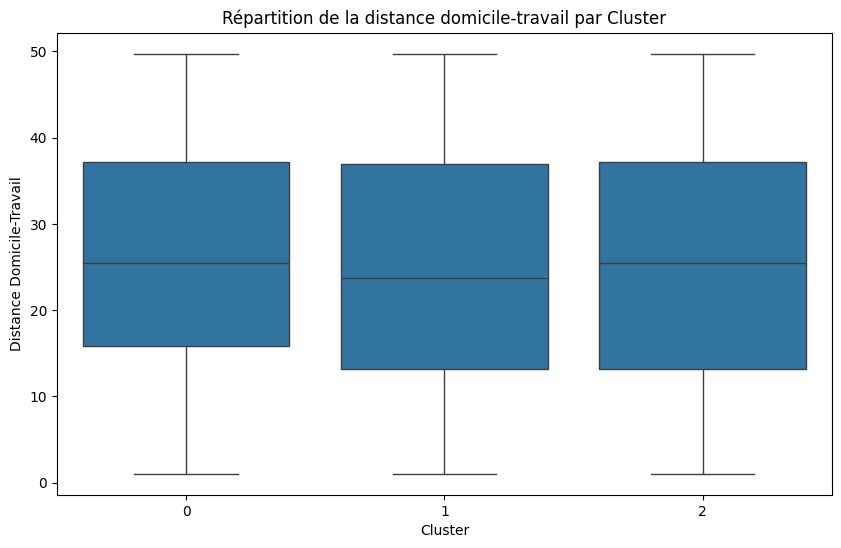

In [91]:
# Tracer les distributions de l'âge et de la distance domicile-travail
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='age', data=aggregated_df)
plt.title('Répartition de l\'âge par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Âge')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='distancetravailmaison', data=aggregated_df)
plt.title('Répartition de la distance domicile-travail par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Distance Domicile-Travail')
plt.show()


##### observation

les clusters sont relativement proche entre eux, mais statistiquement, des ecarts se remarquent

In [103]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(scaled_data, aggregated_df['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.17873440286904677


####  évaluation est très faible car nous manquons  à la fois de données et les données sont peu dispersés

### test autres models segmentations

DBSCAN n'a trouvé qu'un seul cluster, silhouette score non applicable.
Silhouette Score Agglomerative Clustering: 0.2615262168392601
Silhouette Score GMM: 0.5432697013672445


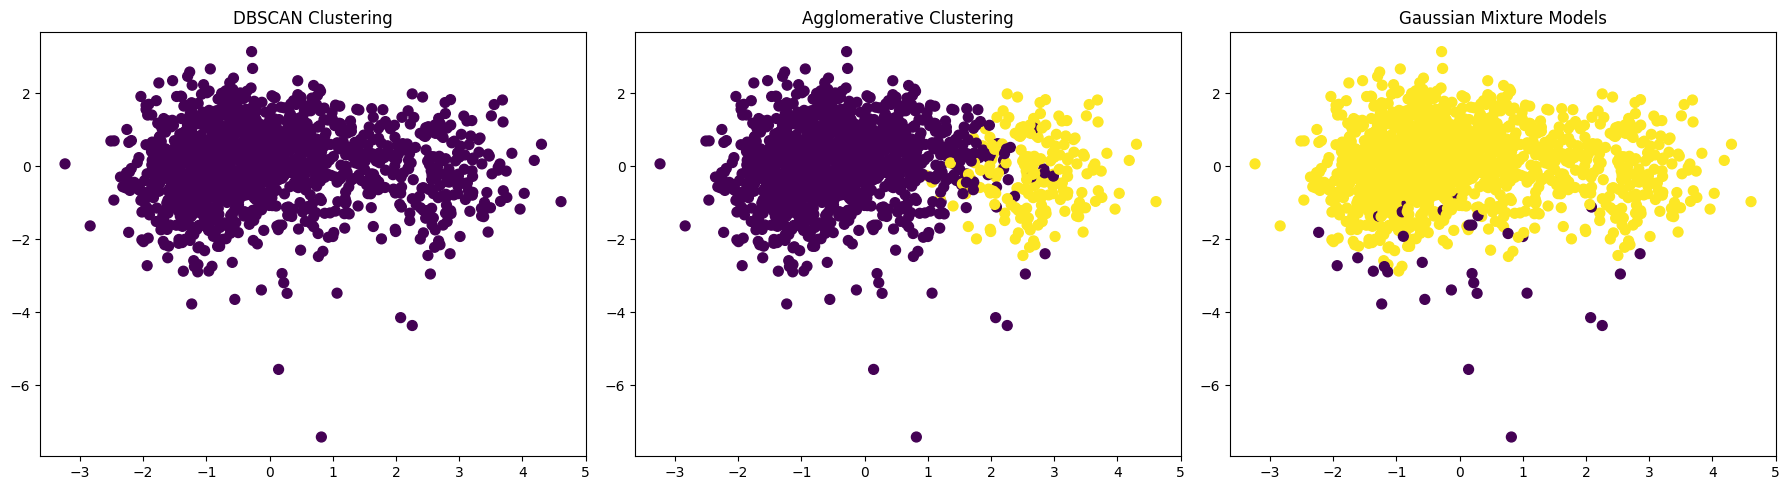

In [118]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normaliser les données avant de les utiliser pour les algorithmes de clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(aggregated_df[numeric_columns])

# --- DBSCAN ---
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Vérifier si DBSCAN a trouvé plusieurs clusters ou seulement un
if len(set(dbscan_labels)) > 3:
    silhouette_dbscan = silhouette_score(scaled_data, dbscan_labels)
else:
    silhouette_dbscan = None
    print("DBSCAN n'a trouvé qu'un seul cluster, silhouette score non applicable.")

# --- Agglomerative Clustering ---
agg_clust = AgglomerativeClustering(n_clusters=2)#Ajuster le nombre de clusters si nécessaire
agg_clust_labels = agg_clust.fit_predict(scaled_data)

# --- Gaussian Mixture Model ---
gmm = GaussianMixture(n_components=2,random_state=42)  # Ajuster le nombre de composants
gmm_labels = gmm.fit_predict(scaled_data)

# Afficher le Silhouette Score pour chaque modèle
if silhouette_dbscan is not None:
    print("Silhouette Score DBSCAN:", silhouette_dbscan)
print("Silhouette Score Agglomerative Clustering:", silhouette_score(scaled_data, agg_clust_labels))
print("Silhouette Score GMM:", silhouette_score(scaled_data, gmm_labels))

# --- Visualisation des résultats ---
# Choisir les 2 premières composantes principales pour la visualisation
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Tracer les résultats de chaque clustering
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# DBSCAN
axes[0].scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_labels, cmap='viridis', s=50)
axes[0].set_title('DBSCAN Clustering')

# Agglomerative Clustering
axes[1].scatter(pca_data[:, 0], pca_data[:, 1], c=agg_clust_labels, cmap='viridis', s=50)
axes[1].set_title('Agglomerative Clustering')

# GMM
axes[2].scatter(pca_data[:, 0], pca_data[:, 1], c=gmm_labels, cmap='viridis', s=50)
axes[2].set_title('Gaussian Mixture Models')

# Afficher les graphiques
plt.tight_layout()
plt.show()


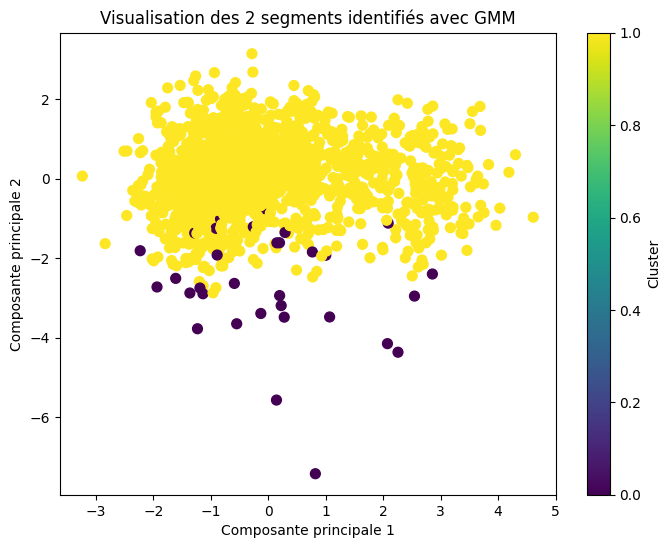

In [112]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Appliquer PCA pour réduire les dimensions à 2 pour la visualisation
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Tracer les 2 segments identifiés par GMM
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=gmm_labels, cmap='viridis', s=50)

# Ajouter un titre et des labels aux axes
plt.title('Visualisation des 2 segments identifiés avec GMM')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')

# Afficher le graphique
plt.colorbar(label='Cluster')
plt.show()


### remarque

un score de 0.54 suggère que les clusters identifiés par GMM sont relativement bien séparés, bien que cela pourrait être amélioré. Un score plus élevé indique généralement une meilleure séparation des clusters

## Profiling des clusters 

In [114]:
!pip install ace_tools


  Using cached ace_tools-0.0-py3-none-any.whl.metadata (300 bytes)
Using cached ace_tools-0.0-py3-none-any.whl (1.1 kB)


In [116]:
# Profiling des clusters : statistiques descriptives
cluster_profiles = aggregated_df.groupby('Cluster').agg({
    'co2total': ['mean', 'std', 'min', 'max'],
    'co2emistransport': ['mean', 'std', 'min', 'max'],
    'co2emischauffage': ['mean', 'std', 'min', 'max'],
    'co2emisalimentation': ['mean', 'std', 'min', 'max'],
    'distancetravailmaison': ['mean', 'std', 'min', 'max'],
    'globalrank': ['mean', 'std', 'min', 'max'],
    'age': ['mean', 'std', 'min', 'max']
})

# Afficher le profil des clusters dans la console
print("Profil des Clusters :")
print(cluster_profiles)


Profil des Clusters :
            co2total                                      co2emistransport  \
                mean         std         min          max             mean   
Cluster                                                                      
0        1281.728061  435.342737  507.566116  1998.923924        31.188973   
1        1460.029316  313.221515  707.793932  1998.669347        24.392296   
2         657.107477  232.095915  100.381585  1264.794467        24.682726   

                                        co2emischauffage            ...  \
              std        min        max             mean       std  ...   
Cluster                                                             ...   
0        2.962708  24.375321  37.895742        28.301568  2.734000  ...   
1        2.216505  18.590060  30.628418        22.201899  2.364109  ...   
2        2.259720  18.169450  30.477836        19.036711  3.689863  ...   

        distancetravailmaison            globalrank       

Analyse :
CO2 Total : Le Cluster 1 génère les émissions les plus élevées en termes de CO2 total (1460.03), tandis que le Cluster 2 génère les émissions les plus faibles (657.11).
CO2 Transport : Le Cluster 0 a les émissions de CO2 les plus élevées liées au transport (31.19), indiquant une empreinte plus importante dans ce domaine. En revanche, le Cluster 1 a des émissions de transport plus faibles (24.39).
CO2 Chauffage : Le Cluster 0 a les émissions les plus élevées pour le chauffage (28.30), et le Cluster 2 les plus faibles (19.04).
CO2 Alimentation : Le Cluster 0 a les émissions les plus élevées pour l'alimentation (12.57), tandis que le Cluster 1 génère les émissions alimentaires les plus faibles (8.81).
Distance Domicile-Travail : Les distances pour le travail varient, mais le Cluster 0 a la distance la plus longue en moyenne (26.49 km).
Rang Global : Les rangs sont relativement similaires entre les clusters, avec une légère différence entre les clusters, mais ils restent proches de la moyenne de 3.
Âge : Les âges varient légèrement entre les clusters, mais les différences restent faibles (environ 40 ans en moyenne).
Conclusion :
Les trois clusters présentent des comportements différents en termes de leurs empreintes carbone. Le Cluster 1 semble être le plus polluant dans la plupart des catégories (CO2 total et transport), tandis que le Cluster 2 est plus soucieux de l'environnement avec des émissions plus faibles et des distances domicile-travail moins longues.

Si vous cherchez à optimiser les pratiques RSE dans votre organisation, des stratégies ciblées peuvent être développées pour chaque cluster, en mettant l'accent sur la réduction des émissions de transport pour le Cluster 0 et sur l'encouragement de comportements encore plus durables pour le Cluster 2.

### ## Cluster 0 : Le Plus Polluant en CO2 Transport et Chauffage

### Caractéristiques :
- **CO2 Total élevé** (1281.73).
- **CO2 Transport élevé** (31.19) et **Distance Domicile-Travail élevée** (26.49 km).
- **CO2 Chauffage élevé** (28.30).
- **CO2 Alimentation élevé** (12.57).

### Stratégies recommandées :

#### 1. Optimisation du transport :
- Encourager l'utilisation de **transports en commun**, le **covoiturage**, ou le **télétravail** pour réduire les distances domicile-travail.
- Subventionner l'achat de **véhicules écologiques** (électriques ou hybrides) ou mettre en place des incitations pour les déplacements en vélo.
- Mise en place de solutions de **mobilité douce** : stations de vélos ou trottinettes électriques, par exemple.

#### 2. Amélioration de l'efficacité énergétique du chauffage :
- Encourager l'**isolation thermique** et la **rénovation énergétique** des foyers des employés.
- Subventionner l'achat de **chauffages plus efficaces** ou encourager l'usage de **sources d'énergie renouvelables** (solaire, géothermie).
- Organiser des **ateliers de sensibilisation** sur les comportements écoénergétiques.

#### 3. Réduction des émissions alimentaires :
- Promouvoir une **alimentation plus durable** (réduction de la consommation de viande, produits locaux et de saison).
- Sensibiliser les employés à l'impact environnemental des habitudes alimentaires et proposer des menus alternatifs plus respectueux de l'environnement.

#### 4. Sensibilisation et Formation :
- Organiser des **campagnes de sensibilisation** à la réduction des émissions de CO2, en particulier sur les thèmes du transport, du chauffage et de l'alimentation.
- Fournir des **outils de calcul** de l'empreinte carbone personnelle, pour encourager les employés à suivre et à réduire leur propre impact.

---

## Cluster 1 : Emissions Modérées, Mais Élevées en Transport

### Caractéristiques :
- **CO2 Total élevé** (1460.03), mais moins que le Cluster 0.
- **CO2 Transport moins élevé** (24.39) que le Cluster 0.
- **CO2 Chauffage modéré** (22.20) et **CO2 Alimentation modéré** (8.81).
- **Distance Domicile-Travail plus faible** que le Cluster 0 (24.97 km).

### Stratégies recommandées :

#### 1. Réduction du CO2 Transport :
- Continuer à promouvoir l'usage de **transports durables**, tout en renforçant les programmes de **covoiturage** ou en incitant à l'utilisation de **véhicules électriques**.
- Mettre en place un système de **compensation des émissions de CO2**, par exemple, un programme d'achat de crédits carbone pour les trajets en voiture.

#### 2. Optimisation de la consommation énergétique :
- Continuer à promouvoir des solutions d'**efficacité énergétique** pour le chauffage, mais l'accent pourrait être moins marqué ici par rapport au Cluster 0.
- Récompenser l'usage de **chauffage alternatif** respectueux de l'environnement.

#### 3. Réduction de l'empreinte alimentaire :
- Proposer des alternatives alimentaires **durables** à bas impact carbone pour encourager des choix alimentaires plus responsables.
- Encourager les employés à **consommer davantage de végétaux** et à réduire leur consommation d'aliments fortement polluants (viandes, produits industriels).

#### 4. Engagement dans des défis RSE :
- Encourager la participation à des **programmes RSE internes**, comme des défis pour réduire les émissions de CO2 ou améliorer l'efficacité énergétique.

#### 5. Sensibilisation à l'impact personnel :
- Offrir des **formations** sur les choix écologiques en matière de transport, de chauffage et d'alimentation.
- Fournir des **outils personnalisés** de suivi des émissions de CO2.

---

## Cluster 2 : Le Plus Écologique avec des Émissions Relativement Faibles

### Caractéristiques :
- **CO2 Total faible** (657.11).
- **CO2 Transport faible** (24.68).
- **CO2 Chauffage faible** (19.04) et **CO2 Alimentation modéré** (9.84).
- **Distance Domicile-Travail plus faible** que les autres clusters (25.63 km).

### Stratégies recommandées :

#### 1. Renforcement des pratiques écologiques :
- Offrir des **récompenses** ou des **incitations** pour les employés du Cluster 2 pour maintenir et améliorer leurs pratiques écologiques (par exemple, des primes pour l'usage de **transports non polluants**).
- Organiser des **évaluations périodiques** de l'empreinte carbone des employés et offrir des **récompenses** pour les bonnes pratiques.

#### 2. Partage des meilleures pratiques :
- Encourager les employés du Cluster 2 à **partager leurs stratégies écologiques** avec d'autres clusters.
- Créer des **ambassadeurs RSE** pour diffuser les bonnes pratiques.

#### 3. Soutien aux pratiques alimentaires écologiques :
- Continuer à encourager des choix alimentaires **durables**, mais aussi proposer des **incitations** pour encourager la consommation d'aliments à faible empreinte carbone.

#### 4. Programmes de reconnaissance :
- Mettre en place des **récompenses collectives** pour les équipes avec des performances environnementales exceptionnelles.
- Organiser des **événements de reconnaissance publique** pour ces employés afin de les encourager à continuer leurs pratiques écologiques.

#### 5. Innovation en matière de durabilité :
- Encourager la participation à des **projets pilotes** pour tester de nouvelles solutions écologiques (par exemple, des bâtiments à **énergie positive**, des **transports non polluants**).

---

## Conclusion :

- **Cluster 0** : Priorité à la **réduction des émissions de transport** et au passage à des pratiques **énergétiques plus efficaces** pour réduire l'empreinte carbone globale.
- **Cluster 1** : **Optimisation de l'utilisation des transports écologiques** et amélioration des habitudes de consommation énergétique et alimentaire.
- **Cluster 2** : Encouragement de l'**innovation en matière de durabilité** et renforcement des bonnes pratiques écologiques déjà présentes.

# Modèle de prévision


## Objectif

Prévoir les trends et évolutions des émissions par type et de rejet de co2 total afin de pouvoir prendre des mesures et être à y remédier ou encourager les initiatives

In [119]:
import pandas as pd
from sqlalchemy import create_engine

# Configuration de la base de données
DB_CONFIG = {
    "host": "localhost",        
    "database": "ClashOfRse",  
    "user": "your_username", 
    "password": "your_password", 
}

# Connexion via SQLAlchemy
db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
engine = create_engine(db_url)

# Requête pour récupérer les données nécessaires, y compris les informations temporelles
query = """
SELECT 
    b.BEGESId,
    b.ProfilId,
    b.CO2Total,
    t.CO2EmisTransport AS co2emistransport,
    c.CO2EmisChauffage AS co2emischauffage,
    a.CO2EmisAlimentation AS co2emisalimentation,
    p.DateDeNaissance,
    p.DistanceTravailMaison,
    p.RoleId,
    b.GlobalRank,
    b.DateDebut AS start_date,   -- Ajout de la date de début de l'émission
    b.DateFin AS end_date       -- Ajout de la date de fin de l'émission
FROM BEGES b
LEFT JOIN TransportEmission t ON b.BEGESId = t.BEGESId
LEFT JOIN ChauffageEmission c ON b.BEGESId = c.BEGESId
LEFT JOIN AlimentationEmission a ON b.BEGESId = a.BEGESId
LEFT JOIN Profil p ON b.ProfilId = p.ProfilId;
"""

# Charger les données dans un DataFrame pandas
df = pd.read_sql_query(query, con=engine)

# Convertir les dates en format datetime
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Aperçu des données
print(df.head())


   begesid  profilid    co2total  co2emistransport  co2emischauffage  \
0        1        40  347.579996         44.684813         13.063832   
1        1        40  347.579996         44.684813          3.075403   
2        1        40  347.579996         44.684813          1.938048   
3        1        40  347.579996         44.684813         11.176539   
4        1        40  347.579996         44.684813         28.914466   

   co2emisalimentation datedenaissance  distancetravailmaison  roleid  \
0            14.483508      1984-10-19               6.529713       4   
1            14.483508      1984-10-19               6.529713       4   
2            14.483508      1984-10-19               6.529713       4   
3            14.483508      1984-10-19               6.529713       4   
4            14.483508      1984-10-19               6.529713       4   

   globalrank start_date   end_date  
0           3 2023-06-30 2023-07-30  
1           3 2023-06-30 2023-07-30  
2           3 

In [122]:
import pandas as pd

# Assurez-vous que les colonnes 'start_date' et 'end_date' sont de type datetime
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Calculer l'âge à partir de la date de naissance
df['datedenaissance'] = pd.to_datetime(df['datedenaissance'])  # Assurez-vous que la date de naissance est bien au bon format
df['age'] = (pd.to_datetime('today') - df['datedenaissance']).dt.days // 365  # Calculer l'âge en années

# Étape 1 : Calculer les émissions mensuelles par utilisateur

# Extraire l'année et le mois à partir des dates
df['start_month'] = df['start_date'].dt.to_period('M')  # Utilisation de 'M' pour un regroupement par mois
df['end_month'] = df['end_date'].dt.to_period('M')

# Agréger les émissions de CO2 par profil (utilisateur) et par mois
df_agg = df.groupby(['profilid', 'start_month']).agg({
    'co2total': 'sum',
    'co2emistransport': 'sum',
    'co2emischauffage': 'sum',
    'co2emisalimentation': 'sum',
    'distancetravailmaison': 'mean',  # Calculer la distance moyenne domicile-travail
    'globalrank': 'mean',              # Utilisation de 'globalrank' comme nom de la colonne
    'age': 'mean'                      # Utilisation de 'age' après le calcul
}).reset_index()

# Afficher les données agrégées
print(df_agg.head())

# Étape 2 : Préparer les features pour la modélisation
# Vous pouvez ajouter d'autres caractéristiques comme 'RoleId' ou d'autres informations contextuelles

# Exemple d'encodage d'une variable catégorielle
df_agg['roleid_encoded'] = df_agg['globalrank'].astype('category').cat.codes  # Encodage de 'globalrank'

# Vérification des données préparées
print(df_agg.head())


   profilid start_month      co2total  co2emistransport  co2emischauffage  \
0         1     2023-01  2.628645e+07      1.443330e+06      1.368025e+06   
1         1     2023-02  6.782968e+06      1.998338e+05      9.411979e+04   
2         1     2023-03  5.190141e+07      1.066006e+06      8.092831e+05   
3         1     2023-04  1.033830e+07      3.913990e+05      3.449338e+05   
4         1     2023-05  5.461576e+07      1.547965e+06      1.119619e+06   

   co2emisalimentation  distancetravailmaison  globalrank   age  
0        517293.370322               4.510607         3.0  53.0  
1         90236.650673               4.510607         3.0  53.0  
2        341087.854391               4.510607         3.0  53.0  
3        112850.846106               4.510607         3.0  53.0  
4        704438.982251               4.510607         3.0  53.0  
   profilid start_month      co2total  co2emistransport  co2emischauffage  \
0         1     2023-01  2.628645e+07      1.443330e+06      1.3

In [125]:
# Vérification des valeurs manquantes
print(df.isnull().sum())

# gestion des valeurs manquantes
# Sélectionner uniquement les colonnes numériques
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Vérification des colonnes numériques
print(numerical_columns)

# Remplacer les NaN dans les colonnes numériques
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())




begesid                     0
profilid                    0
co2total                    0
co2emistransport            0
co2emischauffage            0
co2emisalimentation      1980
datedenaissance             0
distancetravailmaison       0
roleid                      0
globalrank                  0
start_date                  0
end_date                    0
start_month                 0
end_month                   0
age                         0
dtype: int64
Index(['begesid', 'profilid', 'co2total', 'co2emistransport',
       'co2emischauffage', 'co2emisalimentation', 'distancetravailmaison',
       'roleid', 'globalrank', 'age'],
      dtype='object')


In [126]:
print(df.isnull().sum())


print(df_agg.dtypes)  # Vérifier les types des colonnes après l'agrégation


begesid                  0
profilid                 0
co2total                 0
co2emistransport         0
co2emischauffage         0
co2emisalimentation      0
datedenaissance          0
distancetravailmaison    0
roleid                   0
globalrank               0
start_date               0
end_date                 0
start_month              0
end_month                0
age                      0
dtype: int64
profilid                     int64
start_month              period[M]
co2total                   float64
co2emistransport           float64
co2emischauffage           float64
co2emisalimentation        float64
distancetravailmaison      float64
globalrank                 float64
age                        float64
roleid_encoded                int8
dtype: object


### normalisation des echelles de données


In [127]:
from sklearn.preprocessing import StandardScaler

# Sélectionner les colonnes numériques pour la mise à l'échelle
numerical_features = ['co2total', 'co2emistransport', 'co2emischauffage', 'co2emisalimentation', 'distancetravailmaison', 'age']
scaler = StandardScaler()
df_agg[numerical_features] = scaler.fit_transform(df_agg[numerical_features])

# Vérifier les données après mise à l'échelle
print(df_agg.head())


   profilid start_month  co2total  co2emistransport  co2emischauffage  \
0         1     2023-01  0.118339          2.288076          2.767010   
1         1     2023-02 -1.098831         -0.918894         -1.189635   
2         1     2023-03  1.716912          1.314960          1.031604   
3         1     2023-04 -0.876950         -0.424848         -0.410627   
4         1     2023-05  1.886309          2.557928          1.995480   

   co2emisalimentation  distancetravailmaison  globalrank       age  \
0             1.997037               -1.45196         3.0  1.541345   
1            -0.810452               -1.45196         3.0  1.541345   
2             0.838655               -1.45196         3.0  1.541345   
3            -0.661785               -1.45196         3.0  1.541345   
4             3.227340               -1.45196         3.0  1.541345   

   roleid_encoded  
0              17  
1              17  
2              17  
3              17  
4              17  


#### Correlation

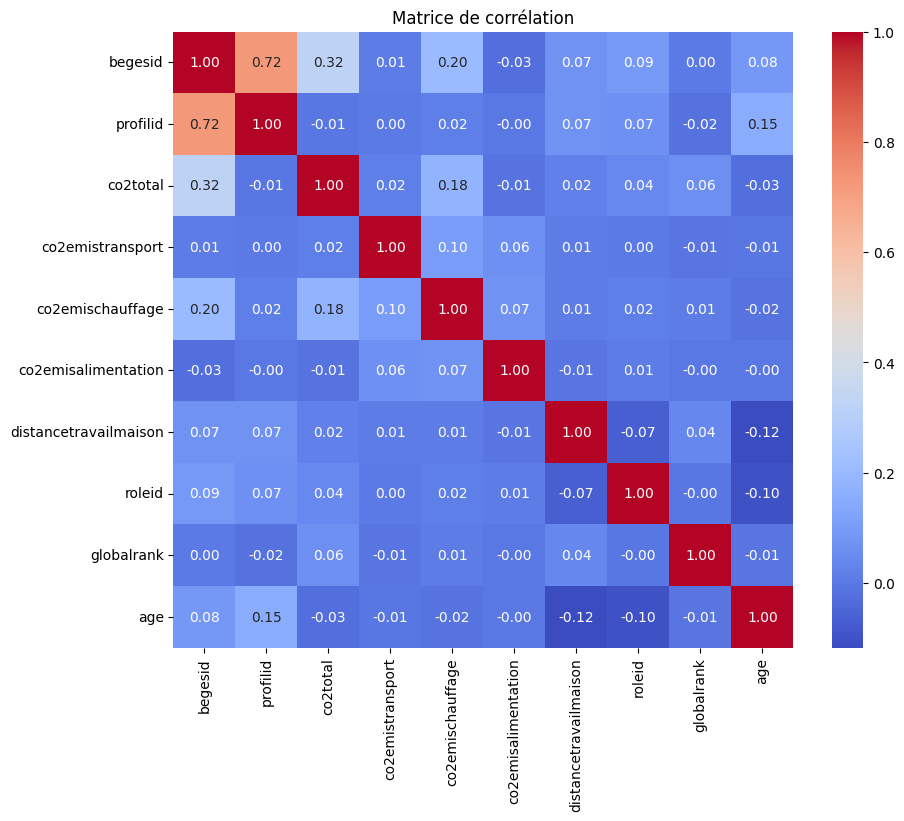

In [129]:
# Sélectionner uniquement les colonnes numériques
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculer la matrice de corrélation uniquement sur les colonnes numériques
corr_matrix = df[numerical_columns].corr()

# Afficher la matrice de corrélation sous forme de heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Matrice de corrélation")
plt.show()


#### Observation 

Non strong correlation

#### Modélisation

### approche regression

In [134]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Sélection des variables indépendantes et dépendantes
X = df_agg[['age', 'distancetravailmaison', 'globalrank', 'co2emistransport', 'co2emischauffage', 'co2emisalimentation']]
y = df_agg['co2total']

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialiser les modèles de régression
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

# Initialiser le TimeSeriesSplit pour la validation croisée
tscv = TimeSeriesSplit(n_splits=5)  # Diviser les données en 5 folds

# Dictionnaire pour stocker les résultats
results = {}

# Entraîner et évaluer chaque modèle
for name, model in models.items():
    fold_mse = []  # Liste pour stocker l'erreur quadratique moyenne (MSE) de chaque fold
    print(f"Training {name}...")

    for train_index, test_index in tscv.split(X_scaled):
        # Sélectionner les ensembles d'entraînement et de test
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Entraîner le modèle
        model.fit(X_train, y_train)
        
        # Prédictions sur l'ensemble de test
        y_pred = model.predict(X_test)
        
        # Calculer l'erreur quadratique moyenne
        mse = mean_squared_error(y_test, y_pred)
        fold_mse.append(mse)

    # Moyenne des erreurs pour chaque modèle
    avg_mse = sum(fold_mse) / len(fold_mse)
    results[name] = avg_mse
    print(f"{name} - Average MSE: {avg_mse}")

# Afficher les résultats
print("\nResults from Cross-Validation:")
for model_name, mse in results.items():
    print(f"{model_name}: {mse}")


Training LinearRegression...
LinearRegression - Average MSE: 0.2906351607617202
Training Ridge...
Ridge - Average MSE: 0.2894180503209426
Training Lasso...
Lasso - Average MSE: 0.9765190429554206
Training RandomForest...
RandomForest - Average MSE: 0.32334949354558395
Training DecisionTree...
DecisionTree - Average MSE: 0.5939493830549345

Results from Cross-Validation:
LinearRegression: 0.2906351607617202
Ridge: 0.2894180503209426
Lasso: 0.9765190429554206
RandomForest: 0.32334949354558395
DecisionTree: 0.5939493830549345


#### observation


Le fait que le Lasso (L1 regularization) montre des résultats significativement meilleurs que les autres modèles pourrait être dû à plusieurs raisons. Voici quelques facteurs potentiels qui pourraient expliquer cette différence :

1. Régularisation (Pénalisation)
Lasso ajoute une régularisation basée sur la norme L1 (la somme des valeurs absolues des coefficients) aux coefficients du modèle. Cela peut conduire à un rétrécissement des coefficients de certaines variables, voire à des coefficients nuls pour certaines d'entre elles. Cela peut être particulièrement utile si vous avez beaucoup de variables peu informatives ou bruitées, car le Lasso les élimine automatiquement, améliorant ainsi la performance du modèle sur les données de test.
Ridge utilise une régularisation L2 (norme au carré des coefficients), ce qui peut être moins efficace si vous avez des variables inutiles ou redondantes, car elle ne met pas les coefficients à zéro. Cela pourrait expliquer pourquoi Ridge ne performe pas aussi bien que le Lasso.
2. Simplicité du modèle
Le Lasso tend à donner un modèle plus simple en éliminant certaines variables. Si beaucoup de vos caractéristiques ne sont pas pertinentes, cela pourrait réduire le surapprentissage (overfitting) et améliorer les performances sur les données de test.
D'autre part, des modèles comme RandomForest ou DecisionTree sont plus complexes et peuvent facilement être trop adaptés aux données d'entraînement, en capturant du bruit ou des relations inutiles dans les données, ce qui entraîne une plus grande variance dans leurs performances.
3. Interaction entre les variables
Si certaines des variables dans votre ensemble de données sont fortement corrélées entre elles, cela peut entraîner une multicolinéarité, ce qui affecte négativement les modèles linéaires classiques comme LinearRegression, Ridge, et Lasso. Cependant, Lasso étant plus sensible à cette multicolinéarité, il pourrait mieux gérer la situation en supprimant complètement certaines de ces variables corrélées.
RandomForest et DecisionTree ne sont pas affectés par la multicolinéarité de la même manière, mais ils peuvent être plus susceptibles de capturer des relations non pertinentes.
4. Caractéristiques des données
Le Lasso peut également être plus performant lorsque les caractéristiques (features) sont déjà bien sélectionnées et lorsque le modèle linéaire est une bonne approximation des relations dans les données.
Les modèles comme RandomForest et DecisionTree peuvent être très efficaces sur des jeux de données avec des relations complexes non linéaires, mais si vos données sont essentiellement linéaires (ou presque), ces modèles peuvent en fait surapprendre et se montrer moins performants.
5. Examen de la performance sur les données spécifiques
Pour comprendre plus en profondeur, il serait utile d'examiner vos données et de tester des aspects spécifiques :
Distribuer les variables : Vérifier la distribution des variables d'entrée pourrait vous donner des indices. Si certaines variables sont mal distribuées, cela peut fausser les résultats des modèles non linéaires comme les arbres.
Corrélation entre les features : Si vos variables sont fortement corrélées, cela peut avantager Lasso par rapport aux autres modèles.
Impact des outliers : Lasso est également plus robuste face aux outliers par rapport aux modèles comme la régression linéaire classique.